1. SET UP

1.1 Import dependencies

In [1]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
from keras.models import Model
from keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf
import uuid

1.2 Set GPU growth

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


1.3 Create folder structures

In [3]:
INP_PATH = os.path.join('Imagenes', 'entrada')
POSI_PATH = os.path.join('Imagenes', 'Positivo')
NEGA_PATH = os.path.join('Imagenes', 'Negativo')
NEGAF_PATH = os.path.join('Imagenes', 'Negativo_final')

In [4]:
# os.makedirs(INP_PATH)
# os.makedirs(POSI_PATH)
# os.makedirs(NEGA_PATH)

2. COLLECT POSITIVES ANCHORS AND NEGATIVES

2,1 Collect positives and achor classes

In [5]:
faceClassif = cv2.CascadeClassifier('Rostros.xml')
cap = cv2.VideoCapture(0)
# while True:
# 	ret,frame = cap.read()
# 	gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# 	faces = faceClassif.detectMultiScale(gray, 1.3, 5)

# 	for (x,y,w,h) in faces:
# 		cv2.rectangle(frame, (x,y),(x+w,y+h),(0,255,0),2)

# 	cv2.imshow('frame',frame)

# 	if cv2.waitKey(1) & 0XFF == ord('a'):
# 		for (x, y, w, h) in faces: 
# 			cv2.rectangle(frame,(x, y),(x+w, y+h),(0, 0, 255), 2)
# 			faces = frame[y:y + h, x:x + w]
# 			faces = cv2.resize(faces,(100,100), interpolation=cv2.INTER_CUBIC)
# 		imgname = os.path.join(INP_PATH, '{}.jpg'.format(uuid.uuid1()))
# 		cv2.imwrite(imgname, faces)

# 	if cv2.waitKey(1) & 0XFF == ord('p'):
# 		for (x, y, w, h) in faces: 
# 			cv2.rectangle(frame,(x, y),(x+w, y+h),(0, 0, 255), 2)
# 			faces = frame[y:y + h, x:x + w]
# 			faces = cv2.resize(faces,(100,100), interpolation=cv2.INTER_CUBIC)
# 		imgname = os.path.join(POSI_PATH, '{}.jpg'.format(uuid.uuid1()))
# 		cv2.imwrite(imgname, faces)
		
# 	if cv2.waitKey(1) & 0xFF == ord('q'):
# 		break
# cap.release()
# cv2.destroyAllWindows()

2.2 Collect negatives classes

In [6]:
## Resizing images from negative folder and relocating into another folder

# Negativo = "C:\\Users\\artur\\OneDrive\\Documentos\\Practica1\\Redes neuronales\\Imagenes\\Prueba"
# files_names = os.listdir(Negativo)
# #print(files_names)


# Negativo_final = "C:\\Users\\artur\\OneDrive\\Documentos\\Practica1\\Redes neuronales\\Imagenes\\Negativo_final"
# if not os.path.exists(Negativo_final):
#     os.makedirs(Negativo_final)
  
# for file_name in files_names:
#     #print(file_name)
#     image_path = Negativo + "/" + file_name
#     print(image_path)
#     image = cv2.imread(image_path)
#     if image is None:
#         continue
#     # cv2.imshow("img1",image)

#     faces = faceClassif.detectMultiScale(image, 1.1, 5)
#     for(x,y,w,h) in faces:
#         # cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),1)
#         faces = image[y:y + h, x:x + w]
#         faces = cv2.resize(faces, (100, 100), interpolation=cv2.INTER_CUBIC)
#     #cv2.imshow('IMAGEN1',faces)
#     imgname = os.path.join(Negativo_final, '{}.jpg'.format(uuid.uuid1()))
#     cv2.imwrite(imgname, faces)
# #cv2.imshow("Image", faces)
# print(len(Negativo_final))
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [7]:
# import cvzone
# from cvzone.SelfiSegmentationModule import SelfiSegmentation
# import os
# from pathlib import Path

# segmentor = SelfiSegmentation()
# files = os.listdir("imagenes")
# black = (0, 0, 0)
# count_persons = 0
# for file in files:
#     folder = Path('imagenes', file)
#     images = os.listdir(folder)
#     number_images = len(images)
#     count_image = 0
#     for image in images:
#         person_two = Path(folder, images[count_image])
#         imgOffice = cv2.imread(str(person_two))
#         imgNoBg = segmentor.removeBG(imgOffice, black, threshold=0.9)
#         cv2.imwrite(str(person_two), imgNoBg)
#         count_image = count_image + 1
#     count_persons = count_persons + 1

3. LOAD AND PREPROCESS IMAGES

3.1 Get image directories

In [8]:
entrada = tf.data.Dataset.list_files(INP_PATH+'\*.jpg').take(500) #take 500 images from anchor folder
Positivo = tf.data.Dataset.list_files(POSI_PATH+'\*.jpg').take(500) #take 500 images from positive folder
Negativ0_final = tf.data.Dataset.list_files(NEGAF_PATH+'\*.jpg').take(3000) #take 3000 images from negative folder

3.2 Preprocess-Resize images

In [9]:
# Function to preprocess the images
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)

    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

3.3 Create labelled dataset

In [10]:
positivos = tf.data.Dataset.zip((entrada, Positivo, tf.data.Dataset.from_tensor_slices(tf.ones(len(entrada)))))
negativos = tf.data.Dataset.zip((entrada, Negativ0_final, tf.data.Dataset.from_tensor_slices(tf.zeros(len(entrada)))))
data = positivos.concatenate(negativos)

samples = data.as_numpy_iterator()

exampple = samples.next()

exampple

(b'Imagenes\\entrada\\9ea8530b-465d-11ed-b6d6-9c4376278c47.jpg',
 b'Imagenes\\Positivo\\b70b485b-465f-11ed-94fe-9c4376278c47.jpg',
 1.0)

3.4 Build train and test partition

In [11]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [12]:
res = preprocess_twin(*exampple)

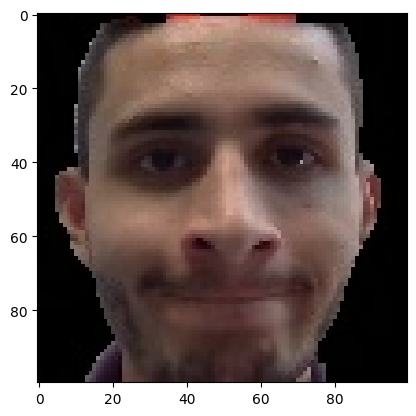

In [13]:
plt.imshow(res[0])

In [14]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [15]:
samples = data.as_numpy_iterator()

In [16]:
samp= samples.next()

In [17]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [18]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

4. MODEL ENGINEERING

4.1 Build embedding layer

In [19]:
inp = Input(shape=(100,100,3), name='input_image')
print(inp)

KerasTensor(type_spec=TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name='input_image'), name='input_image', description="created by layer 'input_image'")


In [20]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)
print(c1)

KerasTensor(type_spec=TensorSpec(shape=(None, 91, 91, 64), dtype=tf.float32, name=None), name='conv2d/Relu:0', description="created by layer 'conv2d'")


In [21]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
print(m1)

KerasTensor(type_spec=TensorSpec(shape=(None, 46, 46, 64), dtype=tf.float32, name=None), name='max_pooling2d/MaxPool:0', description="created by layer 'max_pooling2d'")


In [22]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
print(c2)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
print(m2)

KerasTensor(type_spec=TensorSpec(shape=(None, 40, 40, 128), dtype=tf.float32, name=None), name='conv2d_1/Relu:0', description="created by layer 'conv2d_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 20, 20, 128), dtype=tf.float32, name=None), name='max_pooling2d_1/MaxPool:0', description="created by layer 'max_pooling2d_1'")


In [23]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
print(c3)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
print(m3)

KerasTensor(type_spec=TensorSpec(shape=(None, 17, 17, 128), dtype=tf.float32, name=None), name='conv2d_2/Relu:0', description="created by layer 'conv2d_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 9, 9, 128), dtype=tf.float32, name=None), name='max_pooling2d_2/MaxPool:0', description="created by layer 'max_pooling2d_2'")


In [24]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [25]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [26]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [27]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [28]:
embedding = make_embedding()

In [29]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

4.2 Build distance layer

In [30]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [31]:
l1 = L1Dist()

4.3 Make siamese model

In [32]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [33]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [34]:
siamese_layer = L1Dist()

In [35]:
distances = siamese_layer(inp_embedding, val_embedding)

In [36]:
classifier = Dense(1, activation='sigmoid')(distances)

In [37]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [38]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [39]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [40]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [41]:
siamese_model = make_siamese_model()

In [42]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

5. TRAINING

5.1 Setup loss and optimizer

In [43]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [44]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

5.2 Establish checkpoints

In [45]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckptRedMia')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

5.3 Build train step function

In [46]:
test_batch = train_data.as_numpy_iterator()

In [47]:
batch_1 = test_batch.next()

In [48]:
X = batch_1[:2]

In [49]:
y = batch_1[2]

In [50]:
y

array([0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0.],
      dtype=float32)

In [51]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

5.4 Build training loop

In [52]:
# Import metric calculations
from keras.metrics import Precision, Recall

In [53]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

5.5 Train the model

In [54]:
EPOCHS = 50

In [55]:
# train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
44/44 [==============================] - 51s 922ms/step
0.4219059 0.20612814 0.9866667

 Epoch 2/50
44/44 [==============================] - 39s 897ms/step
0.17902273 0.90434784 0.9904762

 Epoch 3/50
44/44 [==============================] - 39s 887ms/step
0.1648826 0.9676471 0.987988

 Epoch 4/50
44/44 [==============================] - 38s 864ms/step
0.10257264 0.9826087 0.9941349

 Epoch 5/50
44/44 [==============================] - 38s 874ms/step
0.036664303 0.99439776 0.997191

 Epoch 6/50
44/44 [==============================] - 39s 875ms/step
0.05673855 0.99717516 0.99436617

 Epoch 7/50
44/44 [==============================] - 38s 856ms/step
0.0041893995 0.99122804 1.0

 Epoch 8/50
44/44 [==============================] - 38s 867ms/step
0.0144811785 1.0 1.0

 Epoch 9/50
44/44 [==============================] - 37s

6. EVALUATE MODEL

6.1 Import metrics

In [56]:
# Import metric calculations
from keras.metrics import Precision, Recall

6.2 Make predictions

In [57]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [58]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 34ms/step


In [59]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0]

In [60]:
y_true

array([1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.],
      dtype=float32)

6.3 Calculate metrics

In [61]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [62]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [63]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 0s 43ms/step
1.0 1.0


6.4 Viz results

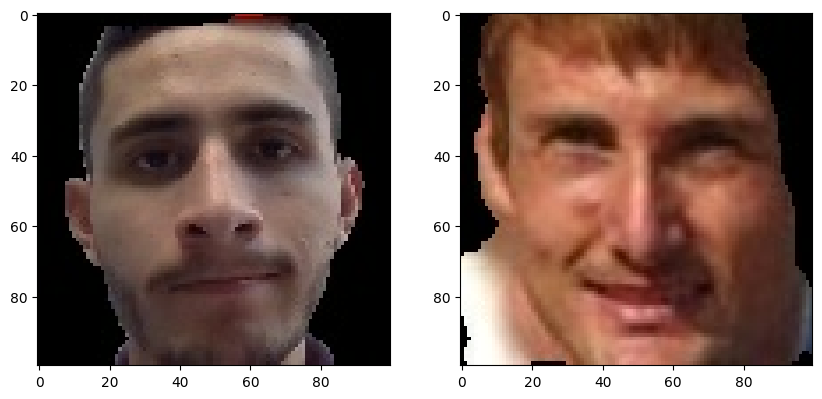

In [64]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[8])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[8])

# Renders cleanly
plt.show()

7. SAVE MODEL

In [65]:
#save weights
# siamese_model.save('MiRed5.h5')

In [66]:
L1Dist

__main__.L1Dist

In [67]:
# Reload model 
siamese_model = tf.keras.models.load_model('MiRed5.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [68]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 203ms/step


array([[9.9999678e-01],
       [1.0000000e+00],
       [3.1343619e-11],
       [7.2694893e-12],
       [9.9997115e-01],
       [7.1635867e-07],
       [1.0000000e+00],
       [1.0000000e+00],
       [3.6013633e-12],
       [9.9999499e-01],
       [9.9999988e-01],
       [9.9999952e-01]], dtype=float32)

In [69]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

8. REAL TIME TEST

8.1 Verification function

In [70]:
os.listdir(os.path.join('application_data', 'verification_images'))

['2c4a434e-465e-11ed-880b-9c4376278c47.jpg',
 '2da96fad-465e-11ed-a64f-9c4376278c47.jpg',
 '3a7c37df-465f-11ed-8df0-9c4376278c47.jpg',
 '56d85fb7-465e-11ed-821a-9c4376278c47.jpg',
 'f11f26ca-465e-11ed-a48a-9c4376278c47.jpg']

In [71]:
VERI_PATH = os.path.join('application_data', 'verification_images')

In [72]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [73]:
import cvzone
from cvzone.SelfiSegmentationModule import SelfiSegmentation
import os
from pathlib import Path
cap = cv2.VideoCapture(0)
while True:
	ret,frame = cap.read()
	gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

	faces = faceClassif.detectMultiScale(gray, 1.3, 5)

	for (x,y,w,h) in faces:
		cv2.rectangle(frame, (x,y),(x+w,y+h),(0,255,0),2)
		
	cv2.imshow('Imagen de entrada',frame)
	if cv2.waitKey(1) & 0XFF == ord('v'):
		for (x, y, w, h) in faces: 
			faces = frame[y:y + h, x:x + w]
			faces = cv2.resize(faces,(100,100), interpolation=cv2.INTER_CUBIC)
			segmentor = SelfiSegmentation()
			green = (0, 0, 0)
			imgNoBg = segmentor.removeBG(faces, green, threshold=0.9)
			cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), imgNoBg)	
	if cv2.waitKey(1) & 0XFF == ord('q'):
		break
cap.release()
cv2.destroyAllWindows()

In [74]:
def verify(model, detection_threshold, verification_threshold, input1, input2 ):
    # Build results array
    results = []

    input_img = preprocess(input1)
    validation_img = preprocess(input2)
    
    # Make Predictions 
    result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
    # results.append(result)


    
    return result

In [87]:
import cvzone
from cvzone.SelfiSegmentationModule import SelfiSegmentation
import os
from pathlib import Path

segmentor = SelfiSegmentation()
persons = os.listdir("Data2")
black = (0, 0, 0)
count_persons = 0
for person in persons:
    folder = Path('Data2', person)
    images = os.listdir(folder)
    number_images = len(images)
    count_image = 0
    for image in images:
        person_two = Path(folder, images[count_image])
        imgOffice = cv2.imread(str(person_two))
        imgNoBg = segmentor.removeBG(imgOffice, black, threshold=0.9)
        cv2.imwrite(str(person_two), imgNoBg)
        count_image = count_image + 1
    count_persons = count_persons + 1

In [96]:
from ast import main
from pathlib import Path, PurePath
from turtle import reset
from unittest import result
caption = os.path.join('application_data', 'input_image', 'input_image.jpg')
def verify3(input_image):
    persons = os.listdir("Data2")
    # p = len(persons)
    results_main = []
    for person in persons:
        folder = Path("Data2", person)
        images= os.listdir(folder)
        count = 0
        # count_images = (len(images))
        for image in images:
            current_person = Path(folder, images[count])
            results = verify(siamese_model, 0.5, 0.5, input_image, str(current_person))
            results_main.append(results)
            count = count + 1
    print(results_main)
    max = np.max(results_main)
    max1 = results_main.index(np.max(results_main))
    print('La imagen de entrada tiene el maximo parecido de',max,'sobre 1 con la imagen ubicada en la posicion',max1)

In [97]:
verify3(caption)

1/1 [==============================] - 0s 20ms/step
[array([[0.00031485]], dtype=float32), array([[0.52858025]], dtype=float32), array([[0.00201801]], dtype=float32), array([[0.68634176]], dtype=float32), array([[0.21458355]], dtype=float32), array([[3.8402513e-06]], dtype=float32), array([[0.05366041]], dtype=float32), array([[0.99602926]], dtype=float32), array([[0.6589163]], dtype=float32)]
La imagen de entrada tiene el maximo parecido de 0.99602926 sobre 1 con la imagen ubicada en la posicion 7
